# Decision Tree ON Fashion-MINIST

In [17]:
import utils.mnist_reader as mnist_reader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

seed = 0
np.random.seed(seed)

import warnings
from sklearn.exceptions import ConvergenceWarning

# Disable ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Load Fashion-MNIST dataset

In [18]:
X, y = mnist_reader.load_mnist('data/fashion', kind='train')

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=seed, shuffle=True) # Train Test Split used for training purposes

X_te, y_te = mnist_reader.load_mnist('data/fashion', kind='t10k') # The actual evaluation dataset

In [19]:
print('Training Set')
print(X_tr.shape) # 45000 rows, each row has 784 columns can be arranged in 28 * 28
print(y_tr.shape) # 45000 classifications

print('\nValuation Set')
print(X_val.shape) # 15000 rows, each row has 784 columns can be arranged in 28 * 28
print(y_val.shape) # 15000 classifications

print('\nTest Set')
print(X_te.shape) # 10000 rows, each row has 784 columns can be arranged in 28 * 28
print(y_te.shape) # 10000 classifications

Training Set
(45000, 784)
(45000,)

Valuation Set
(15000, 784)
(15000,)

Test Set
(10000, 784)
(10000,)


Normalize the dataset

In [20]:
# Normalization
scaler = StandardScaler()
scaler.fit(X)

X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_te)

## Tune Hyperparameters

Find the best parameters with `GridSearchCV`

In [21]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

training_amount = 15000 # valid amounts are between 0 and 45000

# Create the decision tree classifier
tree = DecisionTreeClassifier(random_state=seed)

# Create GridSearchCV object with the decision tree classifier and parameter grid
grid_search = GridSearchCV(tree, param_grid, cv=5)

# Fit the data to perform the grid search
grid_search.fit(X_tr[:training_amount], y_tr[:training_amount])

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

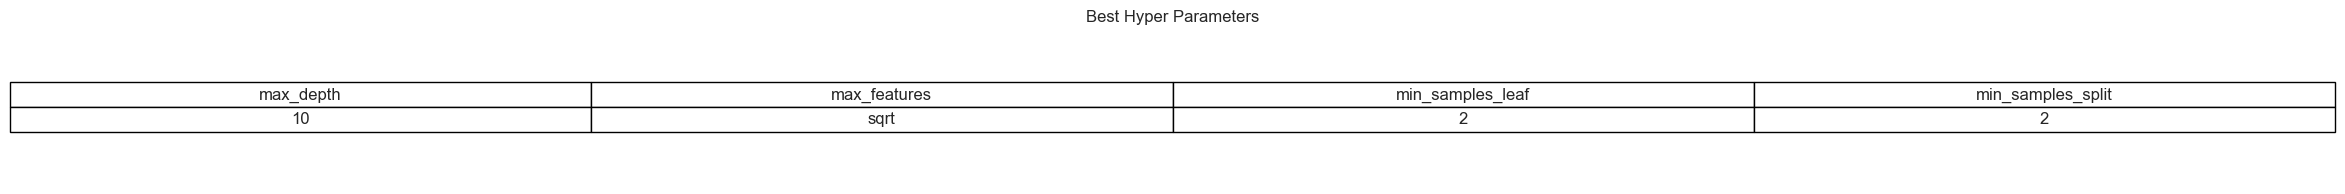

Best Accuracy Score: 0.7686666666666666
    mean_fit_time  std_fit_time  mean_score_time  std_score_time   
0        0.172974      0.031427         0.001946        0.000491  \
1        0.150677      0.002975         0.001665        0.000121   
2        0.146402      0.003340         0.001690        0.000157   
3        0.142833      0.003495         0.001675        0.000086   
4        0.142662      0.003482         0.001618        0.000064   
..            ...           ...              ...             ...   
67       0.056693      0.001321         0.001568        0.000064   
68       0.052974      0.000693         0.001556        0.000051   
69       0.055452      0.001035         0.001640        0.000071   
70       0.055029      0.002327         0.001595        0.000083   
71       0.055047      0.001057         0.001697        0.000085   

   param_max_depth param_max_features param_min_samples_leaf   
0             None               sqrt                      1  \
1             N

In [22]:
# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create the table to display the results
fig, ax = plt.subplots(figsize=(20, 2))
ax.axis('off')

table_data = [str(best_params), str(best_score)]

parameter_names = sorted(list(best_params.keys()))
parameter_values = [best_params[key] for key in parameter_names]

table = ax.table(cellText=[parameter_values], colLabels=parameter_names, cellLoc='center', loc='center')

# Set the table style
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.title('Best Hyper Parameters')
plt.show()

print(f'Best Accuracy Score: {best_score}')

df = pd.DataFrame(grid_search.cv_results_)
print(df)

## Tuning max_depth

In [34]:
depths = [i for i in range(1, 21)]
tr_errs = []
val_errs = []
te_errs = []

for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, random_state=seed)

    tree.fit(X_tr[:training_amount], y_tr[:training_amount])

    tree_train_pred = tree.predict(X_tr[:training_amount])
    tree_val_pred = tree.predict(X_val)

    tree_train_error = 1 - accuracy_score(y_tr[:training_amount], tree_train_pred)
    tree_val_error = 1 - accuracy_score(y_val, tree_val_pred)

    tr_errs.append(tree_train_error)
    val_errs.append(tree_val_error)

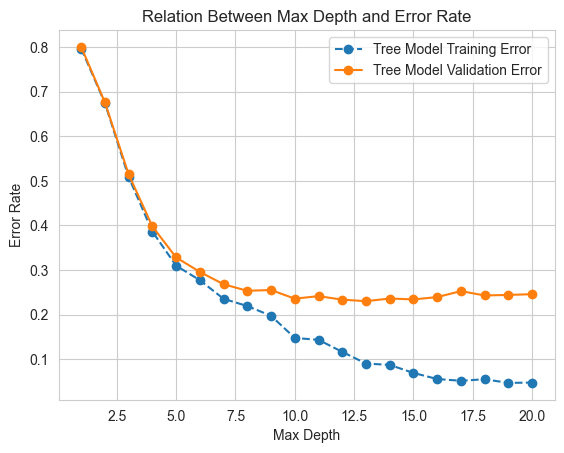

In [35]:
plt.figure()
plt.plot(depths, tr_errs, 'o--', label='Tree Model Training Error')
plt.plot(depths, val_errs, 'o-', label='Tree Model Validation Error')

plt.xlabel('Max Depth')
plt.ylabel('Error Rate')
plt.title('Relation Between Max Depth and Error Rate')

plt.legend()
plt.show()

Analysis: Based on the graph, choosing max_depth = 10 is the most appropriate because the model is not overfitting or underfitting.

Train a `DecisionTreeClassifier` with the best parameters found

In [26]:
# Train the Decision Tree classifier with the best parameters
# tree_best = DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, random_state=seed)
tree_best = DecisionTreeClassifier(**best_params, random_state=seed)
tree_best.fit(X_tr, y_tr)

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       random_state=0)

## Evaluate the classifier

Calculate accuracy scores

In [30]:
y_tr_pred = tree_best.predict(X_tr)
y_val_pred = tree_best.predict(X_val)
y_test_pred = tree_best.predict(X_te)

acc_tr = accuracy_score(y_tr, y_tr_pred)
acc_val = accuracy_score(y_val, y_val_pred)
acc_te = accuracy_score(y_te, y_test_pred)

print(f"The Decision Tree Classifier Has Training Accuracy: {acc_tr}")
print(f"The Decision Tree Classifier Has Validation Accuracy: {acc_val}")
print(f"The Decision Tree Classifier Has Testing Accuracy: {acc_te}")

The Decision Tree Classifier Has Training Accuracy: 0.8171777777777778
The Decision Tree Classifier Has Validation Accuracy: 0.7768
The Decision Tree Classifier Has Testing Accuracy: 0.7759


Create a confusion matrix

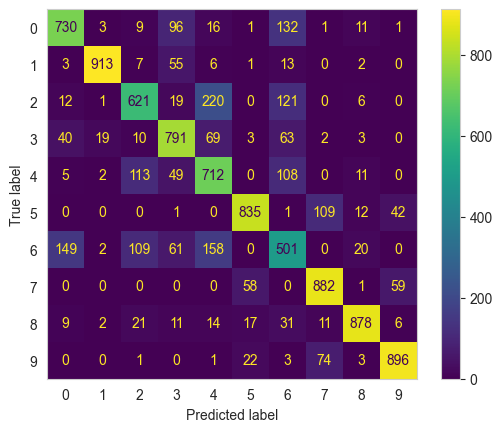

In [31]:
cm = confusion_matrix(y_te, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.grid(False)
plt.show()

Create a classification report

<AxesSubplot: >

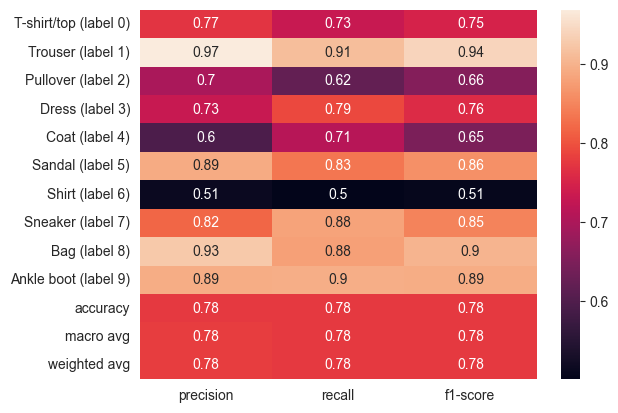

In [32]:
label2desc = {0: 'T-shirt/top (label 0)',
              1: 'Trouser (label 1)',
              2: 'Pullover (label 2)',
              3: 'Dress (label 3)',
              4: 'Coat (label 4)',
              5: 'Sandal (label 5)',
              6: 'Shirt (label 6)',
              7: 'Sneaker (label 7)',
              8: 'Bag (label 8)',
              9: 'Ankle boot (label 9)'}

report = classification_report(y_te, y_test_pred, target_names = label2desc.values(), output_dict=True)

sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)

## Learning Curve

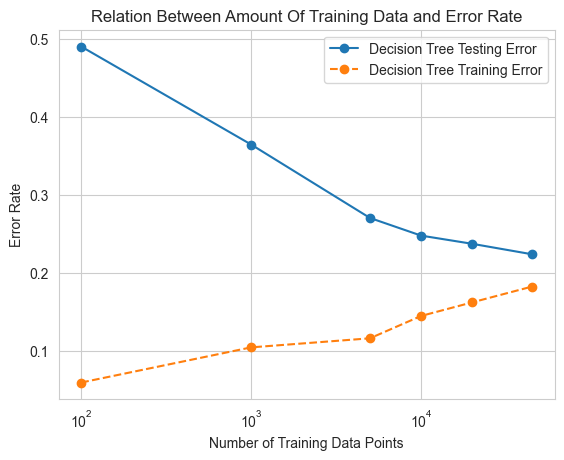

In [33]:
tree_train_errors = []
tree_test_errors = []

n_tr = [100, 1000, 5000, 10000, 20000, 45000]

for n in n_tr:

    # Get a sub portion of feature vectors
    sub_X_tr = X_tr[:n]
    sub_y_tr = y_tr[:n]

    # DecisionTreeClassifier
    tree = DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, random_state=seed)

    tree.fit(sub_X_tr, sub_y_tr)

    mlp_train_pred = tree.predict(X_tr[:n])
    mlp_test_pred = tree.predict(X_te)

    mlp_train_error = 1 - accuracy_score(y_tr[:n], mlp_train_pred[:n])
    mlp_test_error = 1 - accuracy_score(y_te, mlp_test_pred)

    tree_train_errors.append(mlp_train_error)
    tree_test_errors.append(mlp_test_error)

plt.figure()
plt.plot(n_tr, tree_test_errors, 'o-', label='Decision Tree Testing Error')
plt.plot(n_tr, tree_train_errors, 'o--', label='Decision Tree Training Error')

plt.xlabel('Number of Training Data Points')
plt.ylabel('Error Rate')
plt.xscale('log')
plt.title('Relation Between Amount Of Training Data and Error Rate')

plt.legend()
plt.show()